Corona virus cases is increasing day by day in Pakistan and in globe as well and with every day new cases are reporting. 
So, the goal is to make a machine learning model that can predict and forecast new cases, deaths, cure cases based on past data of Pakistan and forecast new cases overall and at Province/state and City level as well as.

Lets connect on other mediums as well:



Video Tutorial: https://youtu.be/Pt76F5rHsRE

Github: https://github.com/uzairaj

Blog: http://uzairadamjee.com/blog/

In [1]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 2.7 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import datetime
import plotly.express as px
import plotly.express as ex
import folium
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima    
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import plotly.graph_objects as go
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
covid_data = pd.read_excel('../input/pak_data-v2.xlsx')


In [4]:
covid_data.head()

,Date,Province,City,New Cases,Cured Cases,Death Cases
0,2020-02-26,Sindh,Karachi,1,0,0
1,2020-02-28,Islamabad,Islamabad,1,0,0
2,2020-03-01,Sindh,Karachi,1,0,0
3,2020-03-01,Islamabad,Islamabad,1,0,0
4,2020-03-03,Gilgit-Baltistan,Gilgit,1,0,0


In [5]:
covid_data.isnull().sum()

Date           0
Province       0
City           0
New Cases      0
Cured Cases    0
Death Cases    0
dtype: int64

In [6]:
covid_data.dtypes

Date           datetime64[ns]
Province               object
City                   object
New Cases               int64
Cured Cases             int64
Death Cases             int64
dtype: object

In [7]:
#start date 
covid_data.Date.min()

Timestamp('2020-02-26 00:00:00')

In [8]:
#max date 
covid_data.Date.max()

Timestamp('2020-04-29 00:00:00')

# PAKISTAN

In [9]:
pak_data = covid_data.copy()

In [10]:
pak_data['Total Confirmed Cases'] = 0
pak_data['Total Recovered'] = 0
pak_data['Total Deaths'] = 0
pak_data['Active Cases'] = 0
for i in range(0, len(pak_data)):
    if (i == 0):
        pak_data['Total Confirmed Cases'].iloc[i] = pak_data['New Cases'].iloc[i]
        pak_data['Total Recovered'].iloc[i] = pak_data['Cured Cases'].iloc[i]
        pak_data['Total Deaths'].iloc[i] = pak_data['Death Cases'].iloc[i]
        pak_data['Active Cases'].iloc[i] = pak_data['Active Cases'].iloc[i-1] + pak_data['New Cases'].iloc[i] - pak_data['Death Cases'].iloc[i] - pak_data['Cured Cases'].iloc[i]

    else:
        pak_data['Total Confirmed Cases'].iloc[i] = pak_data['Total Confirmed Cases'].iloc[i-1] + pak_data['New Cases'].iloc[i]
        pak_data['Total Recovered'].iloc[i] =  pak_data['Total Recovered'].iloc[i-1] + pak_data['Cured Cases'].iloc[i]
        pak_data['Total Deaths'].iloc[i] =  pak_data['Total Deaths'].iloc[i-1] + pak_data['Death Cases'].iloc[i]
        pak_data['Active Cases'].iloc[i] = pak_data['Active Cases'].iloc[i-1] + pak_data['New Cases'].iloc[i] - pak_data['Death Cases'].iloc[i] - pak_data['Cured Cases'].iloc[i]



In [11]:
pak_data.head()

,Date,Province,City,New Cases,Cured Cases,Death Cases,Total Confirmed Cases,Total Recovered,Total Deaths,Active Cases
0,2020-02-26,Sindh,Karachi,1,0,0,1,0,0,1
1,2020-02-28,Islamabad,Islamabad,1,0,0,2,0,0,2
2,2020-03-01,Sindh,Karachi,1,0,0,3,0,0,3
3,2020-03-01,Islamabad,Islamabad,1,0,0,4,0,0,4
4,2020-03-03,Gilgit-Baltistan,Gilgit,1,0,0,5,0,0,5


14278 2971 311 11618


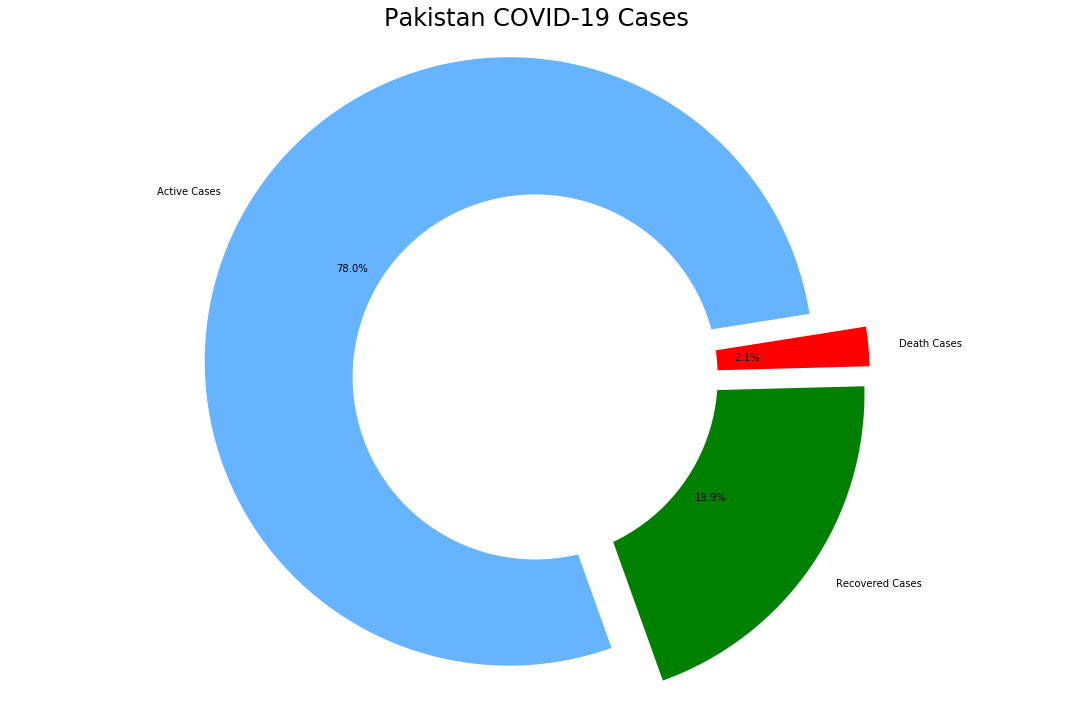

In [12]:
confirmed = pak_data['New Cases'].sum()
recovered = pak_data['Cured Cases'].sum()
deaths = pak_data['Death Cases'].sum()
active = confirmed - (recovered - deaths)

print(confirmed, recovered, deaths, active)

labels = ['Active Cases','Recovered Cases','Death Cases']
sizes = [active,recovered,deaths]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0.1)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%3.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.60,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Pakistan COVID-19 Cases',fontsize = 24)
plt.axis('equal')  
plt.tight_layout()

In [13]:
temp = pak_data.groupby(['Date'])['New Cases','Cured Cases','Death Cases'].sum().reset_index()
fig = px.scatter(temp, x="Date", y="New Cases", color="New Cases",
                 size='New Cases', hover_data=['New Cases'],
                 color_discrete_sequence = ex.colors.cyclical.IceFire)
fig.update_layout(title_text='Trend of Daily Cases in Pakistan',
                  plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Confirmed Cases'],
                    mode='lines+markers',marker_color='blue',name='Confimned Cases'))
#fig.add_trace(go.Scatter(x=train_df['Date'],y=train_df['Active'], 
#                mode='lines+markers',marker_color='purple',name='Active Cases'))
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Recovered'],
                mode='lines+markers',marker_color='green',name='Recovered'))
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Deaths'], 
                mode='lines+markers',marker_color='red',name='Deaths'))
fig.update_layout(title_text='Coronavirus Cases in Pakistan',plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()

# Prophet Model

In [15]:

confirmed = pak_data['Total Confirmed Cases'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(pak_data['Date'])
data['y'] = confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=15)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(15)
#print(forecast)


fig = go.Figure()
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Confirmed Cases'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='Orange',name='Predicted'))
fig.update_layout(title_text = 'Confirmed Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()


In [16]:
deaths = pak_data['Total Deaths'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(pak_data['Date'])
data['y'] = deaths

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=15)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(15)

fig = go.Figure()
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Deaths'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='red',name='Predicted'))
fig.update_layout(title_text = 'Death Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()


In [17]:

recv = pak_data['Total Recovered'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(pak_data['Date'])
data['y'] = recv

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=15)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(15)
print(forecast)
#fig = plot_plotly(prop, prop_forecast)
#fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')


fig = go.Figure()
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Recovered'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='yellow',name='Predicted'))
fig.update_layout(title_text = 'Recovered Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()


             ds         yhat
1343 2020-04-30  3142.916757
1344 2020-05-01  3294.277884
1345 2020-05-02  3446.617257
1346 2020-05-03  3591.504806
1347 2020-05-04  3775.921434
1348 2020-05-05  3867.090071
1349 2020-05-06  3993.020757
1350 2020-05-07  4119.718485
1351 2020-05-08  4271.079612
1352 2020-05-09  4423.418985
1353 2020-05-10  4568.306534
1354 2020-05-11  4752.723162
1355 2020-05-12  4843.891799
1356 2020-05-13  4969.822485
1357 2020-05-14  5096.520213


# Arima Model

In [18]:
cc = pak_data['Total Confirmed Cases'].values


# fit model
p,d,q = auto_arima(cc).order
print(p,d,q)

#model = SARIMAX(chk, order=(p,d,q), seasonal_order=(0,0,0,0),measurement_error=True)#seasonal_order=(1, 1, 1, 1))
model = ARIMA(pak_data['Total Confirmed Cases'],order=(p,d,q))
arima = model.fit(disp=True)
forecast = arima.forecast(steps= 15)
pred = list(forecast[0])
print(pred)
start_date = pak_data['Date'].max()
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date

fig = go.Figure()
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Confirmed Cases'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prediction_dates, y=pred,
                    mode='lines+markers',marker_color='Orange',name='Predicted'))
fig.update_layout(title_text = 'Confirmed cases Predicted vs Actual using ARIMA')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()

3 2 3
[14301.495047213046, 14313.695579376701, 14327.041178009988, 14344.203091357369, 14354.809764640142, 14370.584303156957, 14385.806472295975, 14396.699063972907, 14414.04975167835, 14426.895522599503, 14439.520997275382, 14456.908758761707, 14468.046257411706, 14483.013396577737, 14498.94999961325]


# Sarima Model

In [19]:
cc = pak_data['Total Confirmed Cases'].values


# fit model
p,d,q = auto_arima(cc).order
print(p,d,q)

model = SARIMAX(cc, order=(p,d,q), seasonal_order=(0,0,0,0),measurement_error=True)#seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
        
# make prediction
pred = model_fit.predict(len(cc), len(cc)+7)
print(pred)
        
start_date = pak_data['Date'].max()
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date

fig = go.Figure()
fig.add_trace(go.Scatter(x=pak_data['Date'], y=pak_data['Total Confirmed Cases'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prediction_dates, y=pred,
                    mode='lines+markers',marker_color='Orange',name='Predicted'))
fig.update_layout(title_text = 'Confirmed cases Predicted vs Actual using SARIMA')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()

3 2 3
[14295.28753297 14311.05214378 14320.55942081 14333.57021633
 14345.81945339 14355.95335002 14370.61135818 14379.25625966]


# Province Predictions

In [20]:
province_cases = pak_data.groupby(['Date','Province'])['New Cases','Cured Cases','Death Cases'].sum().reset_index()


In [21]:
province_cases['Total Confirmed Cases'] = 0
province_cases['Total Recovered'] = 0
province_cases['Total Deaths'] = 0
province_cases['Active Cases'] = 0

province_list = province_cases['Province'].unique()
test = province_cases.copy()
for province in province_list:
    
    
    province_data = province_cases[province_cases['Province'] == province]
    
    for i in range(0, len(province_data)):

        if (i == 0):
            province_data['Total Confirmed Cases'].iloc[i] = province_data['New Cases'].iloc[i]
            province_data['Total Recovered'].iloc[i] = province_data['Cured Cases'].iloc[i]
            province_data['Total Deaths'].iloc[i] = province_data['Death Cases'].iloc[i]
            province_data['Active Cases'].iloc[i] = province_data['Active Cases'].iloc[i-1] + province_data['New Cases'].iloc[i] - province_data['Death Cases'].iloc[i] - province_data['Cured Cases'].iloc[i]
        else:
            province_data['Total Confirmed Cases'].iloc[i] = province_data['Total Confirmed Cases'].iloc[i-1] + province_data['New Cases'].iloc[i]
            province_data['Total Recovered'].iloc[i] =  province_data['Total Recovered'].iloc[i-1] + province_data['Cured Cases'].iloc[i]
            province_data['Total Deaths'].iloc[i] =  province_data['Total Deaths'].iloc[i-1] + province_data['Death Cases'].iloc[i]
            province_data['Active Cases'].iloc[i] = province_data['Active Cases'].iloc[i-1] + province_data['New Cases'].iloc[i] - province_data['Death Cases'].iloc[i] - province_data['Cured Cases'].iloc[i]

    
    province_cases.update(province_data)

province_cases = province_cases.astype({"New Cases":int,"Cured Cases":int,"Death Cases":int, "Total Confirmed Cases": int,"Total Recovered":int,"Total Deaths":int,"Active Cases": int})


In [22]:
province_cases.dtypes

Date                     datetime64[ns]
Province                         object
New Cases                         int64
Cured Cases                       int64
Death Cases                       int64
Total Confirmed Cases             int64
Total Recovered                   int64
Total Deaths                      int64
Active Cases                      int64
dtype: object

In [23]:
province_cases.head()

,Date,Province,New Cases,Cured Cases,Death Cases,Total Confirmed Cases,Total Recovered,Total Deaths,Active Cases
0,2020-02-26,Sindh,1,0,0,1,0,0,1
1,2020-02-28,Islamabad,1,0,0,1,0,0,1
2,2020-03-01,Islamabad,1,0,0,2,0,0,2
3,2020-03-01,Sindh,1,0,0,2,0,0,2
4,2020-03-03,Gilgit-Baltistan,1,0,0,1,0,0,1


In [24]:
s_cases = pak_data.groupby('Province')['New Cases','Cured Cases','Death Cases'].sum().reset_index()
s_cases['Active Cases'] = s_cases['New Cases'] - s_cases['Death Cases']- s_cases['Cured Cases']
s_cases["Death Rate (per 100)"] = np.round(100*s_cases["Death Cases"]/s_cases["New Cases"],2)
s_cases["Cure Rate (per 100)"] = np.round(100*s_cases["Cured Cases"]/s_cases["New Cases"],2)
s_cases.sort_values('New Cases', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["New Cases"])\
                        .background_gradient(cmap='Blues',subset=["Death Cases"])\
                        .background_gradient(cmap='Blues',subset=["Cured Cases"])\
                        .background_gradient(cmap='Blues',subset=["Active Cases"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,Province,New Cases,Cured Cases,Death Cases,Active Cases,Death Rate (per 100),Cure Rate (per 100)
5,Punjab,5730,1162,95,4473,1.660000,20.280000
6,Sindh,4956,818,85,4053,1.720000,16.510000
4,KPK,2160,549,114,1497,5.280000,25.420000
1,Balochistan,781,173,10,598,1.280000,22.150000
2,Gilgit-Baltistan,330,221,3,106,0.910000,66.970000
3,Islamabad,261,32,4,225,1.530000,12.260000
0,Azad Kashmir,60,16,0,44,0.000000,26.670000


In [25]:
#province_cases.loc[province_cases['Province'] == 'Sindh']


In [26]:
# For Sindh
s = province_cases.loc[province_cases['Province'] == 'Sindh']

confirmed = s['Total Confirmed Cases'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(s['Date'])
data['y'] = confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = go.Figure()
fig.add_trace(go.Scatter(x=s['Date'], y=s['Total Confirmed Cases'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='Orange',name='Predicted'))
fig.update_layout(title_text = 'Sindh Confirmed Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()


In [27]:
# For Sindh

confirmed = s['Total Deaths'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(s['Date'])
data['y'] = confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = go.Figure()
fig.add_trace(go.Scatter(x=s['Date'], y=s['Total Deaths'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='red',name='Predicted'))
fig.update_layout(title_text = 'Sindh Death Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()


In [28]:
# For Sindh
s = province_cases.loc[province_cases['Province'] == 'Sindh']

confirmed = s['Total Recovered'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(s['Date'])
data['y'] = confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = go.Figure()
fig.add_trace(go.Scatter(x=s['Date'], y=s['Total Recovered'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='yellow',name='Predicted'))
fig.update_layout(title_text = 'Sindh Recovered Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()


# Cities Prediction

In [29]:
cities = pak_data.groupby(['Date', 'City'])['New Cases','Cured Cases','Death Cases'].sum().reset_index()


In [30]:
cities['Total Confirmed Cases'] = 0
cities['Total Recovered'] = 0
cities['Total Deaths'] = 0
cities['Active Cases'] = 0

city_list = cities['City'].unique()
for city in city_list:
    
    
    city_data = cities[cities['City'] == city]
    
    for i in range(0, len(city_data)):

        if (i == 0):
            city_data['Total Confirmed Cases'].iloc[i] = city_data['New Cases'].iloc[i]
            city_data['Total Recovered'].iloc[i] = city_data['Cured Cases'].iloc[i]
            city_data['Total Deaths'].iloc[i] = city_data['Death Cases'].iloc[i]
            city_data['Active Cases'].iloc[i] = city_data['Active Cases'].iloc[i-1] + city_data['New Cases'].iloc[i] - city_data['Death Cases'].iloc[i] - city_data['Cured Cases'].iloc[i]
        else:
            city_data['Total Confirmed Cases'].iloc[i] = city_data['Total Confirmed Cases'].iloc[i-1] + city_data['New Cases'].iloc[i]
            city_data['Total Recovered'].iloc[i] =  city_data['Total Recovered'].iloc[i-1] + city_data['Cured Cases'].iloc[i]
            city_data['Total Deaths'].iloc[i] =  city_data['Total Deaths'].iloc[i-1] + city_data['Death Cases'].iloc[i]
            city_data['Active Cases'].iloc[i] = city_data['Active Cases'].iloc[i-1] + city_data['New Cases'].iloc[i] - city_data['Death Cases'].iloc[i] - city_data['Cured Cases'].iloc[i]

    
    cities.update(city_data)

cities = cities.astype({"New Cases":int,"Cured Cases":int,"Death Cases":int, "Total Confirmed Cases": int,"Total Recovered":int,"Total Deaths":int,"Active Cases": int})


In [31]:
c_cases = cities.groupby('City')['New Cases','Cured Cases','Death Cases'].sum().reset_index()
c_cases = c_cases.sort_values(['New Cases'], ascending=False)

c_cases['Active Cases'] = c_cases['New Cases'] - c_cases['Death Cases']- c_cases['Cured Cases']
c_cases["Death Rate (per 100)"] = np.round(100*c_cases["Death Cases"]/c_cases["New Cases"],2)
c_cases["Cure Rate (per 100)"] = np.round(100*c_cases["Cured Cases"]/c_cases["New Cases"],2)
c_cases.sort_values('New Cases', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["New Cases"])\
                        .background_gradient(cmap='Blues',subset=["Death Cases"])\
                        .background_gradient(cmap='Blues',subset=["Cured Cases"])\
                        .background_gradient(cmap='Blues',subset=["Active Cases"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,City,New Cases,Cured Cases,Death Cases,Active Cases,Death Rate (per 100),Cure Rate (per 100)
41,Karachi,3524,354,79,3091,2.240000,10.050000
92,Raiwind,1925,308,0,1617,0.000000,16.000000
56,Lahore,1494,343,45,1106,3.010000,22.960000
86,Peshawar,800,44,63,693,7.880000,5.500000
19,Dera Ghazi Khan,794,394,0,400,0.000000,49.620000
90,Quetta,621,173,10,438,1.610000,27.860000
111,Sukkur,413,213,2,198,0.480000,51.570000
94,Rawalpindi,296,22,18,256,6.080000,7.430000
34,Hyderabad City,275,169,3,103,1.090000,61.450000
35,Islamabad,261,32,4,225,1.530000,12.260000


In [32]:
khi = cities.loc[cities['City'] == 'Karachi']

confirmed = khi['Total Confirmed Cases'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(khi['Date'])
data['y'] = confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = go.Figure()
fig.add_trace(go.Scatter(x=khi['Date'], y=khi['Total Confirmed Cases'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='Orange',name='Predicted'))
fig.update_layout(title_text = 'Karachi Confirmed Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()


In [33]:
confirmed = khi['Total Deaths'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(khi['Date'])
data['y'] = confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = go.Figure()
fig.add_trace(go.Scatter(x=khi['Date'], y=khi['Total Deaths'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='red',name='Predicted'))
fig.update_layout(title_text = 'Karachi Death Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()

In [34]:
confirmed = khi['Total Recovered'].values.tolist()
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = list(khi['Date'])
data['y'] = confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = go.Figure()
fig.add_trace(go.Scatter(x=khi['Date'], y=khi['Total Recovered'],
                    mode='lines+markers',marker_color='green',name='Actual'))
fig.add_trace(go.Scatter(x=prop_forecast['ds'], y=prop_forecast['yhat_upper'],
                    mode='lines+markers',marker_color='yellow',name='Predicted'))
fig.update_layout(title_text = 'Karachi Recovered Cases (Predicted vs Actual) using Prophet')
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)',width=600, height=600)
fig.show()